# Single Image: Dark Regions Identification

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

## Image Query
Querying a single image from the DESI legacy survey. 

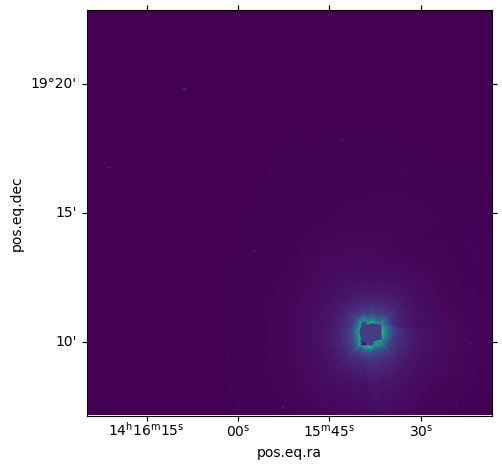

In [21]:
url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
# brick = "0001m002"
brick = "2139p192"
filters = "g"
image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filters}.fits.fz"
#print(image_string)

test_image = fits.open(image_string)
#print(test_image.info())
#print(repr(test_image[1].header))

wcs = WCS(test_image[1].header)

zimage = test_image[1].data

fig = plt.figure()
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
ax.imshow(zimage, norm='linear')

plt.tight_layout()

## Thresholding

There are a few components to calculating 'threshold' value for source extraction. We need to consider subtraction of background noise to identify objects, but then also enforce the limiting magnitude of 21. Start by extracting values from the image header about global background and zero point, and define the limiting magnitude.

In [22]:
def thresh_values(image, mag_limit=21):

    # single number background average
    bkg = sep.Background(image.data)
    sigma_gb = bkg.globalrms

    # zero point
    mag_zero = image.header['MAGZERO']

    return (sigma_gb, mag_zero, mag_limit)

Now create the thresholding function given these extracted values

In [23]:
def threshold_func(image):
    threshold_values = thresh_values(image)
    threshold = (1 / (1.5 * threshold_values[0])) * (10 ** ((threshold_values[1]-  threshold_values[2]) / 2.5))
    return threshold

Finally, run the thresholding function on the given image to find the threshold value.

In [24]:
thresh = threshold_func(test_image[1])
print("Threshold: ", thresh)

Threshold:  234.2871174012311


## Source Extraction
Now that we have our threshold which takes into account our magnitude limit and global background for the image, we can run source extraction from SEP to pull out objects that meet this threshold. Note that the depth of the DESI survey is far greater than the 2.3, so objects may be identified that do not meet the limiting magnitude.

In [25]:
objects = sep.extract(zimage, thresh, segmentation_map=True)
seg_map = objects[1] # the boolean array of light/dark spots is what we need to create the segmentation map.

Plot the background-subtracted image, with ellipses around each object that meets the limiting magnitude.

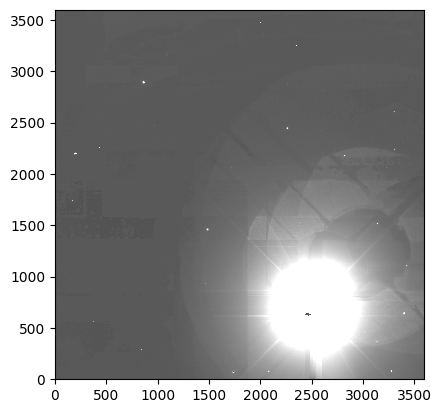

In [26]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(zimage), np.std(zimage)
im = ax.imshow(zimage, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects[0])):
    e = Ellipse(xy=(objects[0]['x'][i], objects[0]['y'][i]),
                width=20*objects[0]['a'][i],
                height=20*objects[0]['b'][i],
                angle=objects[0]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

None of these objetcs are brighter than 21 mag. Plot segmentation map with axes converted to sky coordinates rather than pixels. 

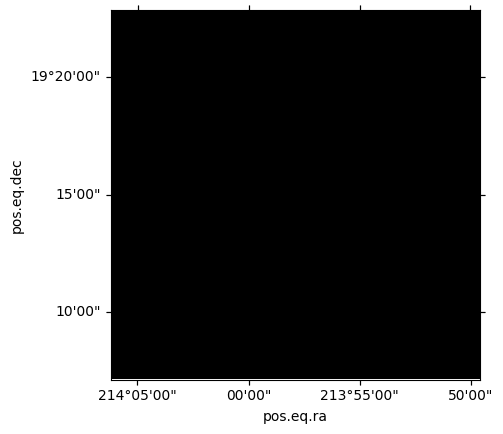

In [27]:
# image coords - pixel scale is uniform for all sources
pixscale = 0.262
ra = test_image[1].header['CRVAL1']
dec = test_image[1].header['CRVAL2']

fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')

## Finding Dark Regions
Now expand the exclusion zones to a 20 arcsec radius around each object (if there were any). The centre of the 2.3 FOV cannot be within these exclusion zones. We also add a grid with 45 arcsec diameter squares to demonstrate all the potential centres of the 2.3m FOV.

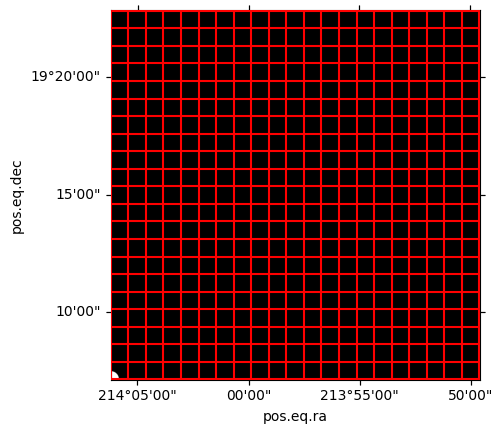

In [28]:
from scipy.ndimage import distance_transform_edt
import astropy.units as u
from astropy.visualization import (MinMaxInterval, ImageNormalize)

# Calculate the distance transform of the seg_map
distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

# Expand seg_map for exclusion zones
excl_map = np.copy(seg_map)
excl_map[distance <= 20] = 1

# creating gric with potential FOV centres
fov = 45
gridscale = fov//pixscale
gridlines = np.arange(0,3600,gridscale)
gridlines = gridlines.astype(int)

# Creating exclusion map with grid
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)

norm = ImageNormalize(excl_map, MinMaxInterval())
plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
plt.vlines(gridlines,0,3600,colors='red')
plt.hlines(gridlines,0,3600,colors='red')
plt.margins(0)
plt.show()

The final step is to find the centre coordinate of every single grid square that does not have any exclusion zone in it. In this case, it is all squares except the bottom left corner. We locate these centres and plot an 'x' on each RADEC coordinate for dark sky regions.

In [29]:
# calculating and storing the centre of each dark coord
centers = []

for i in range(len(gridlines[:-1])):
    centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

x_cen, y_cen = np.meshgrid(centers, centers)
x_grid, y_grid = np.meshgrid(gridlines, gridlines)
dark_regions = []

for i in range(len(gridlines) - 1):
    for j in range(len(gridlines) - 1):
        x_start, x_end = gridlines[i], gridlines[i + 1]
        y_start, y_end = gridlines[j], gridlines[j + 1]
        
        if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
            dark_regions.append([x_cen[j, i], y_cen[j, i]])

dr_trans = np.array(dark_regions).transpose()

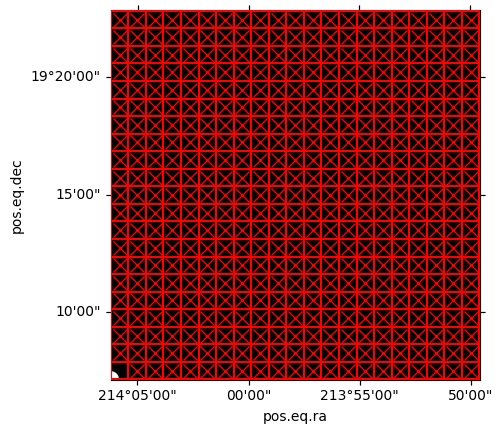

In [30]:
# plotting dark sky regions in the image
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)

norm = ImageNormalize(excl_map, MinMaxInterval())
plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
plt.vlines(gridlines,0,3600,colors='red')
plt.hlines(gridlines,0,3600,colors='red')
plt.margins(0)
plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)
plt.show()

In [31]:
from astropy.coordinates import SkyCoord

# list of dark sky coords
dark_x = []
dark_y = []

for i in range(len(dr_trans[0])):
    dark_x.append(dr_trans[1][i]*pixscale + ra)
    dark_y.append(dr_trans[0][i]*pixscale + dec)

dark_coords = [dark_x, dark_y]

ra_coords = []
dec_coords = []
dr_coords = []

for j in range(len(dark_coords[0])):
    dark_coords_dms = SkyCoord(ra=dark_coords[0][j], dec=dark_coords[1][j], unit='arcsec')
    dr_coords.append(dark_coords_dms)

In [108]:
type(dr_coords[1])

astropy.coordinates.sky_coordinate.SkyCoord